Uses REBOUND commit a675e6f92cba32bae86f94739faec3b1b3098e81

In [1]:
import rebound
rebound.__version__

'3.6.1'

In [2]:
if rebound.__githash__ != 'a675e6f92cba32bae86f94739faec3b1b3098e81':
    print('Should checkout commit above to ensure this runs correctly')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
%matplotlib inline

path = '/mnt/ssd/workspace/stability/stabilitydataset/data/resonant/'
safolder = path+'simulation_archives/runs/'

In [4]:
df = pd.read_csv(path+"resonant.csv", index_col = 0)
df.tail()

,runstring
9995,0009995.bin
9996,0009996.bin
9997,0009997.bin
9998,0009998.bin
9999,0009999.bin


In [5]:
df2 = pd.read_csv(path+"metadata.csv", index_col = 0)
df2.head()

,instability_time,m1,m2,m3,Stable
0,1.545872e+06,3.984920e-06,1.244417e-05,2.531702e-07,False
1,9.990000e+08,2.065557e-07,1.681432e-05,6.830431e-07,True
2,9.990000e+08,1.797281e-07,3.209939e-05,9.648477e-05,True
3,2.287671e+06,4.704418e-05,6.920889e-06,1.615758e-05,False
4,9.668931e+05,3.514145e-06,7.277734e-07,4.655600e-05,False


# Test Reproducibility

When we ran the resonant integrations (with the new simarchive), we did with safe_mode = 0 so we don't repeat kepler half steps. But this also sets sim.ri_whfast.keep_unsynchronized = 0, which you need for reproducibility. A value of 1 means that even if you synchronize, you'll keep integrating from the unsynchronized state if you keep going. So when integrating through a list of times, we need to set this if we want to match the sim archives. Also, the simarchives with safe_mode = 0 will be in an unsynchronized state (see simarchiverestart ipython_example), so we have to synchronize before comparing output.

In [29]:
row = df.loc[0]
sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
tmax = sa[1].t
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1 # this is needed if we want to keep integrating after this
sim.integrate(tmax, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Mar  4 2019 10:26:31
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [30]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Mar  4 2019 10:26:31
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [31]:
def testsim(sa, times):
    sim = sa[0]
    sim.ri_whfast.keep_unsynchronized = 1 # Without this we won't match sim archive, see above
    val = np.zeros((Nout, 18))
    for i, time in enumerate(times):
        orbits = sim.calculate_orbits()
        for j, o in enumerate(orbits):
            val[i,6*j+0] = o.a
            val[i,6*j+1] = o.e
            val[i,6*j+2] = o.inc
            val[i,6*j+3] = o.Omega
            val[i,6*j+4] = o.pomega
            val[i,6*j+5] = o.M
        sim.integrate(time, exact_finish_time=0)
    return sim

In [32]:
Nsys = df.shape[0]
Nout = 1729
times = np.linspace(0, 1e4, Nout)

In [37]:
import rebound
row = df.loc[0]
sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
t1 = sa[1].t
sim = testsim(sa, times)

In [38]:
sim.integrate(t1, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Mar  4 2019 10:26:31
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [36]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Mar  4 2019 10:26:31
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

# Resonant Parameters

The functions 

In [6]:
import random
import numpy as np
from celmech import Andoyer, Poincare, AndoyerHamiltonian
from celmech.andoyer import get_Xstarres
import rebound
from scipy.integrate import ode

def logunif(r, mini, maxi):
    logmin = np.log10(mini)
    logmax = np.log10(maxi)
    return 10**(r.uniform(logmin, logmax))

def get_resonant(seed, Nplanets=3):
    r = random.Random()
    r.seed(seed)

    Phiprimecrits = [0, 1., -2./3.]
    pairs = ['inner', 'outer', 'split']
    
    k=r.randint(1,2) 
    pairindex=r.randint(0,2)
    pair = pairs[pairindex]
    m1 = logunif(r, 1.e-7, 1.e-4)
    m2 = logunif(r, 1.e-7, 1.e-4)
    eH = ((m1+m2)/3.)**(1./3.)
    ehillstable = 3.5*eH
    jmax = k/(1-1/(1+3.5*eH)**1.5)
    if pair == 'split':
        if Nplanets == 2:
            return # don't want 2planet systems 60 hill radii apart
        maxHillradii = 60. # 3rd planet will go in middle so draw up to 60
    else:
        maxHillradii = 30.
    jmin = max(k+1, k/(1-1/(1+maxHillradii*eH)**1.5))
    j = r.randint(np.ceil(jmin), int(np.floor(jmax)))
    a1 = 1.
    a2 = (float(j)/(j-k))**(2./3.)
    ecross1 = (a2-a1)/a1
    ecross2 = (a2-a1)/a2
    emin1 = m2/ecross1**2
    emin2 = m1/ecross2**2
    emin = max(emin1, emin2) # take as min Z the larger of the kicks a planet gets at conjunction       
    emin = max(emin, (m1+m2)**(1./k)) # below mtot^1/k, the resonant term is smaller than the second order mass terms we ignore
    emax = min(ecross1, ecross2)
    
    avars = Andoyer(j=j,k=k,X=0,Y=0,m1=m1, m2=m2)
    Phiprimecrit = Phiprimecrits[k]
    Xcrit = get_Xstarres(k, Phiprimecrit)
    Phicrit = 0.5*Xcrit**2
    emin = max(avars.Phi_to_Z(Phicrit), emin) # first quantity is value of Z at bifurcation when res first appears
    
    Zstar=logunif(r, emin, emax)
    libfac=logunif(r, 3.e-2, 3)
    negative = r.randint(0,1)
    if negative:
        libfac *= -1
    
    avars = Andoyer.from_elements(j=j,k=k,Zstar=Zstar,libfac=libfac, m1=m1, m2=m2, Zcom=logunif(r, emin,emax), phiZcom=r.uniform(0,2*np.pi), theta=r.uniform(0,2*np.pi), theta1=r.uniform(0,2*np.pi))
    tmax = r.uniform(0,10*avars.tlib)
    H = AndoyerHamiltonian(avars)
    H.integrate(tmax)
    pvars = avars.to_Poincare()
    ps = pvars.particles
    if Nplanets==3:
        m3 = logunif(r, 1.e-7, 1.e-4)
        pvarssorted = Poincare(G=pvars.G)

        if pair == "inner":
            eH = ((m2+m3)/3.)**(1./3.)
            beta = r.uniform(3.5,30)
            a3 = a2*(1+beta*eH)
            ecross3 = (a3-a2)/a3
            emin3 = m2/ecross3**2
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))

        elif pair == "outer":
            eH = ((m1+m3)/3.)**(1./3.)
            beta = r.uniform(3.5,30)
            a3 = a1/(1+beta*eH)
            ecross3 = (a1-a3)/a3
            emin3 = m1/ecross3**2
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)

        elif pair == "split":
            eH1 = ((m1+m3)/3.)**(1./3.)
            eH2 = ((m2+m3)/3.)**(1./3.)
            amin = a1*(1+3.5*eH1)
            amax = min(a1*(1+30*eH1), a2/(1+3.5*eH2))
            if amin > amax:
                seed += 900000
                return get_resonant(seed=seed) # draw new sample (may not be 'split')
            a3 = r.uniform(amin, amax)
            ecross3 = min((a3-a1)/a1, (a2-a3)/a3)
            emin3 = max(m1/((a3-a1)/a3)**2, m2/((a2-a3)/a3)**2)
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)
        
        sim = pvarssorted.to_Simulation()
    else:
        sim = avars.to_Simulation()
    # add inclinations and scale s.t. a1 = 1, Mprimary=1. and G = 4*pi**2
    ps = sim.particles
    dscale = ps[1].a
    mscale = ps[0].m
    tscale = np.sqrt(4*np.pi**2*dscale**3/mscale) # = ps[1].P to within mass ratio
    
    siminc = rebound.Simulation()
    siminc.G = sim.G*mscale/dscale**3*tscale**2
    siminc.add(m=ps[0].m/mscale, x=ps[0].x/dscale, y=ps[0].y/dscale, vx=ps[0].vx/dscale*tscale, vy=ps[0].vy/dscale*tscale)
    for p in ps[1:]:
        siminc.add(m=p.m/mscale, a=p.a/dscale, e=p.e, inc=logunif(r, 1.e-3, 1.e-1), Omega=r.uniform(0,2*np.pi), pomega=p.pomega, l=p.l)
        rH = siminc.particles[-1].a*(siminc.particles[-1].m/3./siminc.particles[0].m)**(1./3.) 
        siminc.particles[-1].r = rH
    siminc.move_to_com()
    siminc.integrator="whfast"
    siminc.dt = 2.*np.sqrt(3)/100.*siminc.particles[1].P
    siminc.ri_whfast.safe_mode=0
    siminc.collision="line"
    return siminc, avars

def run_resonant(seed, runstr, Nplanets=3, maxorbs=1.e9, shadow=False):
    success=False
    while not success:
        try:
            sim, avars = get_resonant(seed, Nplanets)
            sim.integrate(1.e4*sim.particles[1].P)
            success=True
        except rebound.Collision:
            seed += 700000 # roughly relatively prime with amin > amax offset above
            
    sim, avars = get_resonant(seed, Nplanets) # get same sim
    return sim, avars, seed

In [7]:
df = pd.read_csv('/mnt/ssd/workspace/stability/stabilitydataset/data/resonant/data.csv', index_col=0)
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


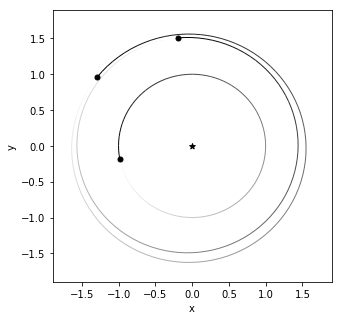

In [16]:
row = df.loc[0]
filename = '/mnt/ssd/workspace/stability/stabilitydataset/data/resonant/simulation_archives/runs/sa'+row['runstring']
sa = rebound.SimulationArchive(filename)
sim = sa[0]
fig = rebound.OrbitPlot(sim)

In [9]:
avars = Andoyer.from_Simulation(sim, row['j'], row['k'], i1=1, i2=2)
print(avars.Zstar, avars.Zcom)

0.01747233040128172 0.039804409115265095


In [12]:
i=0
runstring = "sa{0:0=7d}.bin".format(i)
sim, avars, seed = run_resonant(3500000, runstring)

In [13]:
seed

3500000

In [14]:
sim.t

0.0

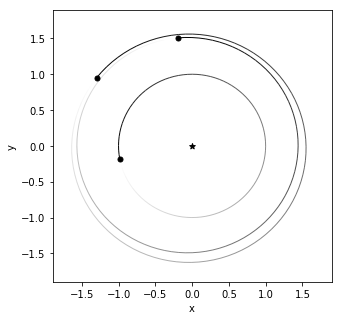

In [15]:
fig = rebound.OrbitPlot(sim)

In [47]:
sim2.t

0.0

In [43]:
avars.Z

0.016873340659951233

In [3]:
%%time
avar = []
for i in range(1000):
    sim, avars = run_resonant(i, '')
    avar.append(avars)

/mnt/raid-cita/dtamayo/venvstab/lib/python3.5/site-packages/scipy/integrate/_ode.py:1266: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 13min 2s, sys: 1.05 s, total: 13min 3s
Wall time: 13min 4s


In [5]:
for a in avar[:20]:
    print(a.Z)

0.016874804607008617
0.03242874835077454
0.026940847930081932
0.025430344565259284
0.017525672925753185
0.0049704265549585566
0.0644541206935496
0.0020130083089420618
0.02234195721009475
0.009147693189638529
0.05439493855717779
0.009993661749911622
0.005887390142776393
0.012703143598489926
0.008865065273092913
0.008090147514988738
0.0012674285774070303
0.04762364277158715
0.043671257523256776
0.0772575582732141


In [7]:
Zs = [a.Z for a in avar]

(array([22., 21., 24., 19., 13.,  8., 16., 11., 10., 56.]),
 array([4.04389016, 4.53950114, 5.03511212, 5.5307231 , 6.02633409,
        6.52194507, 7.01755605, 7.51316703, 8.00877801, 8.504389  ,
        8.99999998]),
 <a list of 10 Patch objects>)

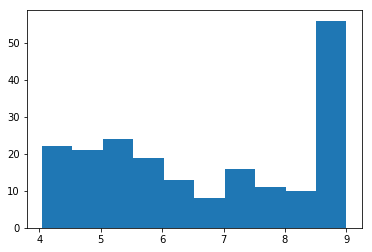

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(np.log10(ts))

(array([  1.,   0.,   3.,   0.,   3.,  38., 158., 367., 330., 100.]),
 array([-5.82357245, -5.2914566 , -4.75934074, -4.22722488, -3.69510903,
        -3.16299317, -2.63087732, -2.09876146, -1.56664561, -1.03452975,
        -0.5024139 ]),
 <a list of 10 Patch objects>)

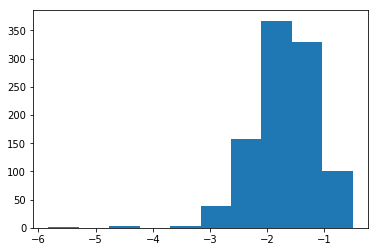

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(np.log10(Zs))

In [13]:
Zcoms = [a.Zcom for a in avar]

(array([ 12.,  33.,  59., 102., 162., 189., 216., 149.,  59.,  19.]),
 array([-3.04564104, -2.7852778 , -2.52491456, -2.26455132, -2.00418808,
        -1.74382484, -1.4834616 , -1.22309837, -0.96273513, -0.70237189,
        -0.44200865]),
 <a list of 10 Patch objects>)

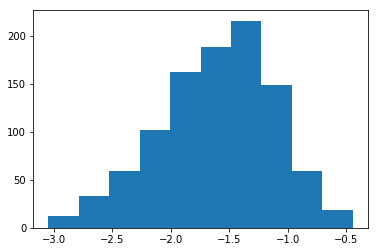

In [32]:
fig, ax = plt.subplots()
ax.hist(np.log10(Zcoms))

In [31]:
%%time

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-5, a=1.)
sim.add(m=1.e-5, a=2.)
sim.add(m=1.e-5, a=3.)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 2*np.sqrt(3)*sim.particles[1].P/100.
sim.integrate(1.e4*sim.particles[1].P)

CPU times: user 399 ms, sys: 1e+03 µs, total: 400 ms
Wall time: 398 ms


In [3]:
import pandas as pd
df = pd.read_csv("../data/csvs/resonant.csv", index_col=0)
df['seed'] = 0
df['pairindex'] = 0
df['j'] = 0
df['k'] = 0
df['Zstar'] = 0
df['libfac'] = 0
df['Zcom'] = 0
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom
0,0000000.bin,0,0,0,0,0,0,0
1,0000001.bin,0,0,0,0,0,0,0
2,0000002.bin,0,0,0,0,0,0,0
3,0000003.bin,0,0,0,0,0,0,0
4,0000004.bin,0,0,0,0,0,0,0


In [5]:
import os
for f in os.listdir('../generate_data/'):
    if "stab" in f and ".o" in f:
        with open('../generate_data/'+f, 'r') as inf:
            lines = inf.readlines()
            vals = lines[0].split(",")
            try:
                ID = int(vals[0])
                df.loc[ID, 'seed'] = int(vals[1])
                df.loc[ID, 'pairindex'] = int(vals[2])
                df.loc[ID, 'j'] = int(vals[3])
                df.loc[ID, 'k'] = int(vals[4])
                df.loc[ID, 'Zstar'] = float(vals[5])
                df.loc[ID, 'libfac'] = float(vals[6])
                df.loc[ID, 'Zcom'] = float(vals[7])
            except:
                print(f)

stab2058.o2040528


In [2]:
import rebound
import numpy as np

def get_time(f):
    try:
        time = rebound.SimulationArchive('../data/resonant/simulation_archives/runs/sa'+f)[-1].t
    except:
        time = np.nan
    return time

def get_shadow_time(f):
    try:
        time = rebound.SimulationArchive('../data/resonant/simulation_archives/shadowruns/sa'+f)[-1].t
    except:
        time = np.nan
    return time
df['instability_time'] = df['runstring'].apply(get_time)

In [15]:
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05


In [6]:
df.to_csv('../data/csvs/data.csv')

In [3]:
df = pd.read_csv('../data/csvs/data.csv')
df['shadow_instability_time'] = df['runstring'].apply(get_shadow_time)
df.head()

,Unnamed: 0,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [5]:
del df['Unnamed: 0']
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [19]:
mask = df['instability_time'] != df['instability_time'] 

In [20]:
df[mask]

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time
2058,0002058.bin,0,0,0,0,0.0,0.0,0.0,NaN


In [21]:
sa = rebound.SimulationArchive('../data/resonant/simulation_archives/runs/sa0002058.bin')

ValueError: ('Cannot read binary file. Check filename and file contents.', 1)

In [1]:
import pandas as pd
df = pd.read_csv('../data/csvs/data.csv', index_col=0)
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05


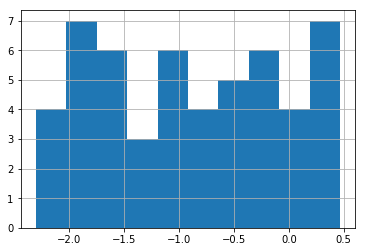

In [163]:
np.log10(np.abs(df[mask]['libfac'])).hist()

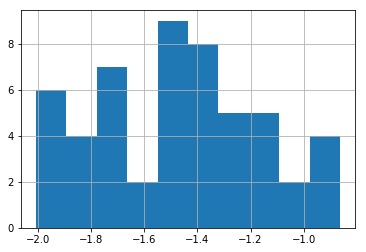

In [167]:
np.log10(np.abs(df[mask]['Zstar'])).hist()

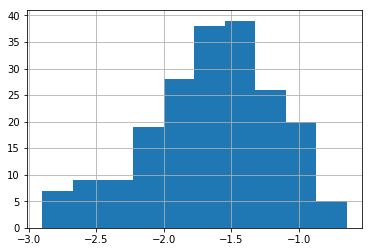

In [168]:
np.log10(np.abs(df['Zstar'])).hist()

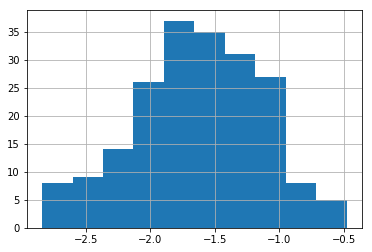

In [169]:
np.log10(np.abs(df['Zcom'])).hist()

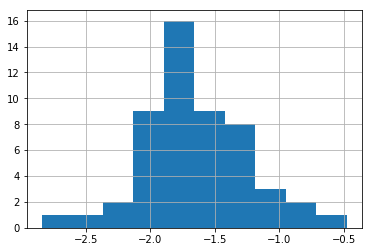

In [170]:
np.log10(np.abs(df[mask]['Zcom'])).hist()

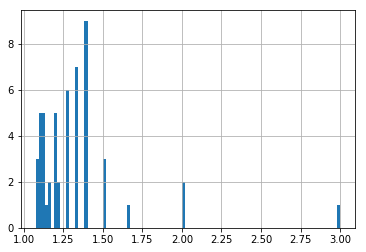

In [183]:
(df[mask]['j']/(df[mask]['j'] - df[mask]['k'])).hist(bins=100)

In [162]:
df[mask]['libfac']

1      0.523204
2      0.012995
12    -2.930812
17    -0.015524
21     0.662838
32     0.434353
40    -1.424688
45     0.028912
56     0.054805
57    -0.214224
64    -0.019672
72    -0.745431
74     2.879162
76    -1.007792
78    -0.301565
79     0.091312
82     0.583487
85     1.224203
86    -0.018586
87     1.780927
90     0.096559
98     0.017302
104   -2.498495
105    0.412323
107   -0.007440
120   -0.073198
123    0.029144
129   -0.039922
135   -0.344473
138    0.019330
139    0.142044
144   -0.005540
147   -0.065287
148    0.208661
151   -0.340097
152    1.539247
154   -0.018045
156    2.244993
158    0.072960
160   -1.674262
164   -0.012184
173   -0.234517
174   -0.015950
180    0.066977
181    0.546857
183    0.014708
184   -0.004967
186    0.037042
189   -0.006528
190   -1.937171
193   -0.167760
196   -0.012160
Name: libfac, dtype: float64